In [151]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
# Importing the dataset
dataset = pd.read_csv('ABS_NOFILTER_12500ELEM.csv')
X_train = dataset.values
y_train = []
for i in range(len(X_train) / 5):
    y_train.append(1) #OUTSIDE
for i in range(len(X_train) / 5+ 1):
    y_train.append(2) # INSIDE
for i in range(len(X_train) / 5 + 1):
    y_train.append(3) # REST 
for i in range(len(X_train) / 5 + 1):
    y_train.append(4) #  FIST 
for i in range(len(X_train) / 5 + 1):
    y_train.append(5) # PINKY
y_train = np.array(y_train)

In [152]:
#FILTERING 
b, a = sp.butter(4, 0.5, 'low')
filtered_channels = []
for i in range(8):
    channel_data = X_train[:, i]
    filtered_channel = sp.filtfilt(b, a, channel_data)
    filtered_channels.append(filtered_channel)
for i in range(8):
    X_train[:, i] = filtered_channels[i]

In [153]:
lda = LDA(n_components=None) #creating a LDA object
lda = lda.fit(X_train, y_train) #learning the projection matrix
# X_lda = lda.transform(X_train) #using the model to project X 
# # .... getting Z as test data....
# Z = lda.transform(X_test) #using the model to project Z
z_labels = lda.predict(X_train) #gives you the predicted label for each sample
print z_labels
print lda.coef_

[4 1 1 ..., 5 5 5]
[[ 0.07568965  0.17793544 -0.04837925 -0.05563627 -0.06209762 -0.0691473
   0.03365831 -0.02525829]
 [-0.03495242 -0.05707907  0.01550214  0.18045671  0.11043656 -0.04885006
  -0.06260821 -0.06003873]
 [-0.04229955 -0.01425247 -0.05810228 -0.06996095 -0.08637552 -0.03370742
  -0.02504608 -0.05564499]
 [ 0.03619236 -0.06336967  0.11382077 -0.04804562  0.00715624  0.17136006
   0.11624089  0.1636385 ]
 [-0.03459977 -0.04316306 -0.02286074 -0.00683612  0.0308555  -0.01968293
  -0.06223144 -0.02270659]]


In [154]:
import pickle
# save the model to disk
filename = 'model_5.sav'
pickle.dump(lda, open(filename, 'wb'))
 
# # some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model.predict(X_train)


array([4, 1, 1, ..., 5, 5, 5])

In [58]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
# Importing the dataset
N = 2000
dataset = pd.read_csv('sliced_LEFT_RIGHT_9550.csv')
y = pd.read_csv('sliced_yTrain.csv').values[250:]
test = pd.read_csv('TEST.csv').values
emg = dataset.values[:N]

(1940, 8)


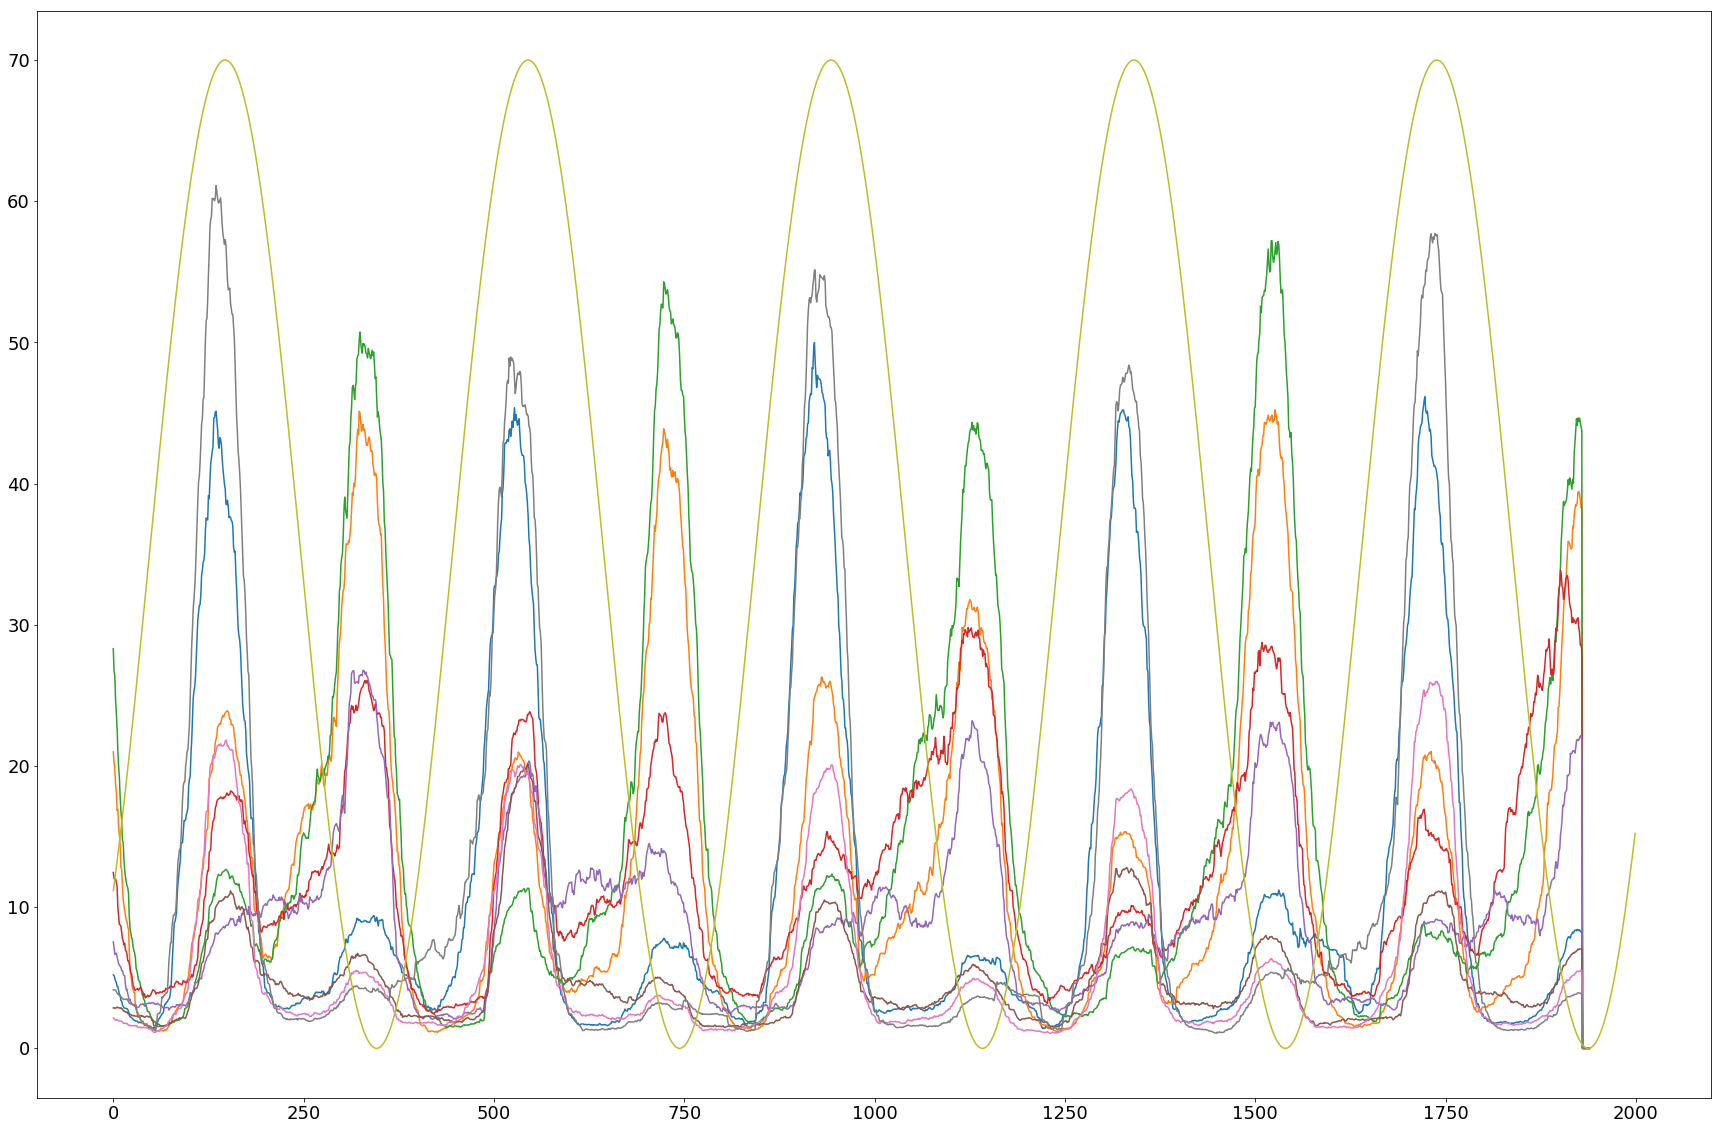

In [59]:
wind_size = 60
i_start = range(1, N-wind_size)
i_stop = range(wind_size, N)
EMG_av = np.zeros((N-wind_size,8))
for i in range(N-10-wind_size):
    sample = np.mean(emg[i_start[i]:i_stop[i],:],axis=0)
    EMG_av[i,:] = sample
    
print(EMG_av.shape)
plt.figure(figsize=(30,20))
plt.plot(EMG_av)
plt.plot(y[:N]*70)
plt.show()


2000


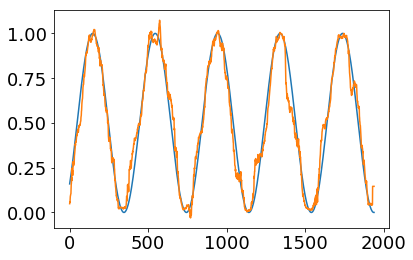

In [60]:
from sklearn.kernel_ridge import KernelRidge
from math import pi,sin
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared
param_grid = {"alpha": 1.0, "gamma": [0.1, 0.01],
              "kernel": [ExpSineSquared(l, p)
                         for l in np.logspace(-2, 2, 10)
                         for p in np.logspace(0, 2, 10)]}
print(N)
kr = KernelRidge(kernel='rbf', gamma=0.001)
trainX = EMG_av
trainY = y[:len(trainX)]
testX = EMG_av[5000:5000+len(trainX)]
kr.fit(trainX, trainY)
pred = kr.predict(trainX)
plt.plot(trainY)
plt.plot(pred)
plt.show()
import pickle
# save the model to disk
filename = '../Models/rbf.sav'
pickle.dump(kr, open(filename, 'wb'))

In [1193]:
#FILTERING 
b, a = sp.butter(30, 0.2, 'low')
filtered_channels = []
for i in range(8):
    channel_data = emg[:, i]
    filtered_channel = sp.filtfilt(b, a, channel_data)
    filtered_channels.append(filtered_channel)
for i in range(8):
    emg[:, i] = filtered_channels[i]
    
testf_channels = []
for i in range(8):
    channel_data = test[:, i]
    filtered_channel = sp.filtfilt(b, a, channel_data)
    testf_channels.append(filtered_channel)
for i in range(8):
    test[:, i] = testf_channels[i]

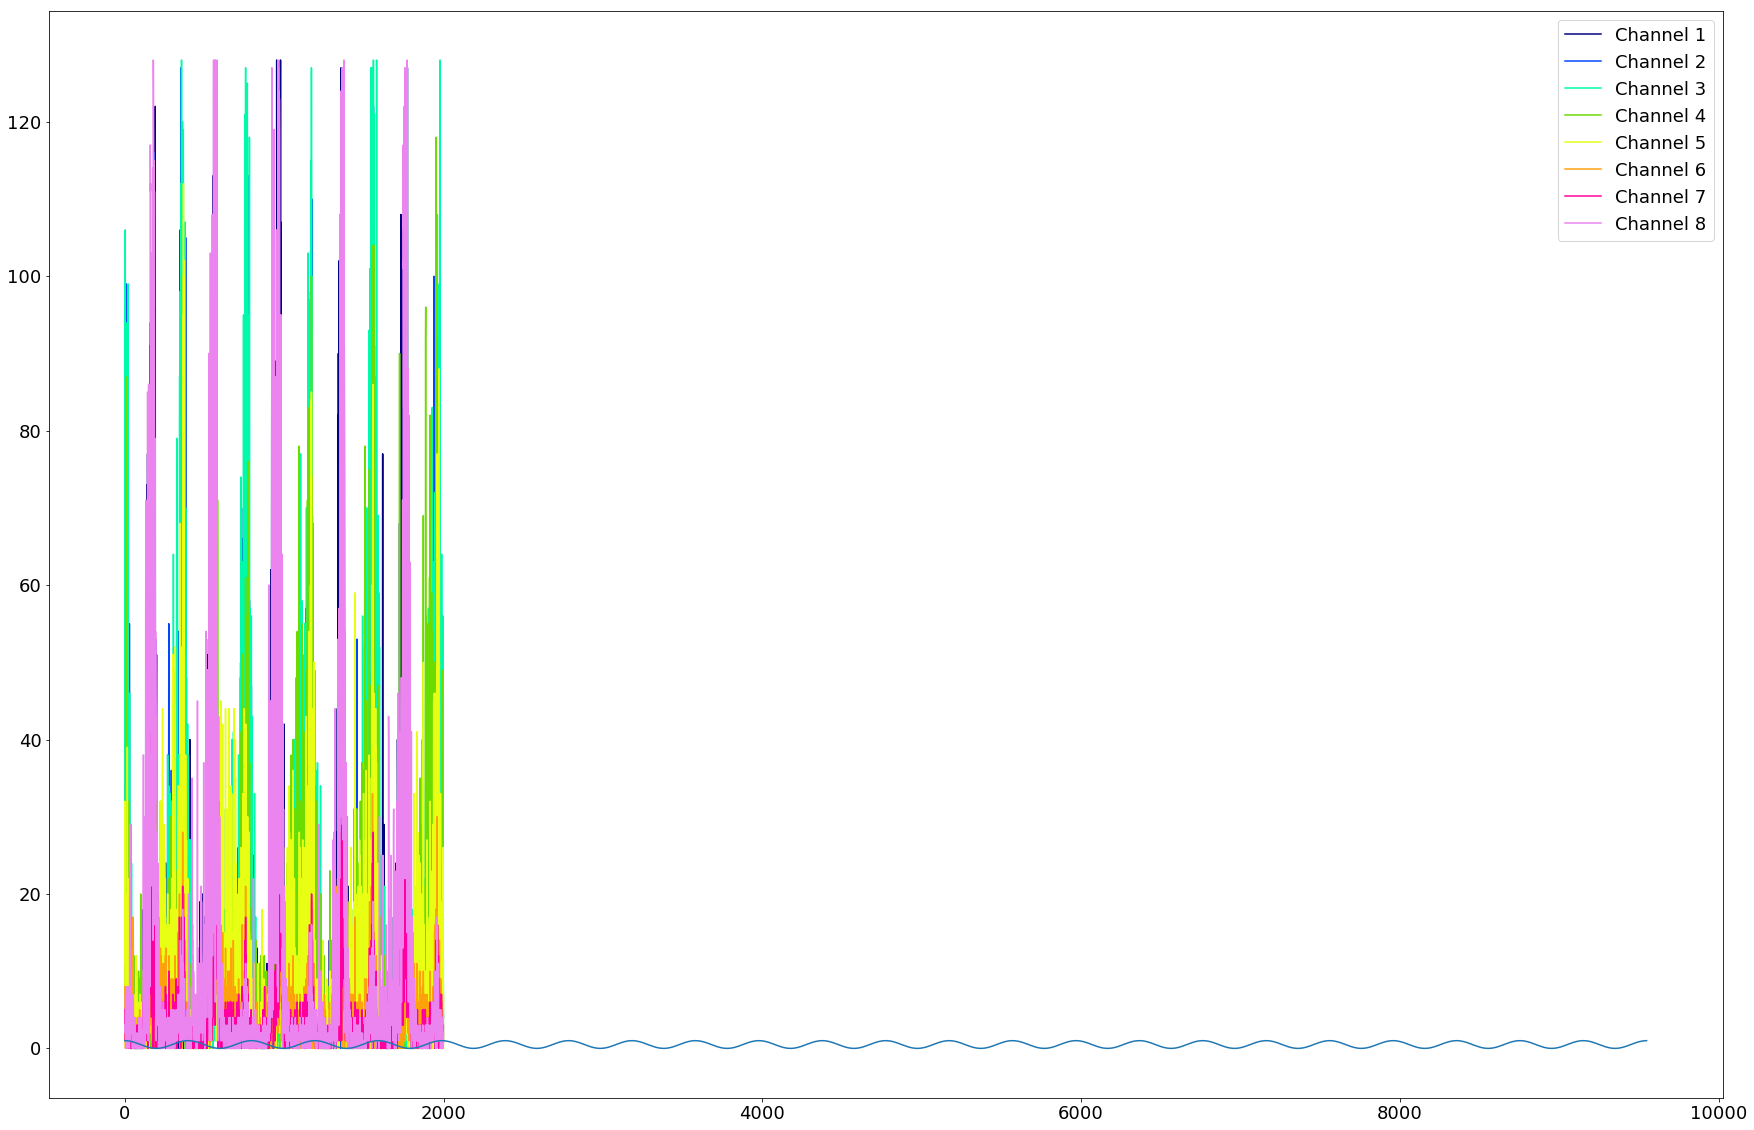

In [1334]:
fig = plt.figure(figsize=(30, 20))
ax = fig.add_subplot(111)
#Making colors
colormap = plt.cm.gist_ncar
colorst = [colormap(i) for i in np.linspace(0, 0.9,8)]  

labeled = False
for i in range(8):
    plt.plot(emg[:,i], label="Channel " + str(i+1), color=colorst[i])


ax.legend(scatterpoints=2,loc='best')
plt.plot(y)
plt.show()

# Average ~5 data points 
# Research windowing in filters (digital)
# Read on IIR FIR 
# Calculate s

In [2]:
from sklearn.kernel_ridge import KernelRidge
from math import pi,sin
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared
param_grid = {"alpha": 1.0, "gamma": [0.1, 0.01],
              "kernel": [ExpSineSquared(l, p)
                         for l in np.logspace(-2, 2, 10)
                         for p in np.logspace(0, 2, 10)]}
kr = KernelRidge(kernel='linear', gamma=0.01)
trainX = EMG_av.flatten().reshape(-1, 1)[:5000]
trainY = np.repeat(y, 8)[:len(trainX)]
testX = EMG_av.flatten().reshape(-1, 1)[5000:10000]
kr.fit(trainX, trainY)
pred = kr.predict(testX)
plt.plot(trainY)
plt.plot(pred)
plt.show()
import pickle
# save the model to disk
filename = 'krr.sav'
pickle.dump(kr, open(filename, 'wb'))

NameError: name 'np' is not defined

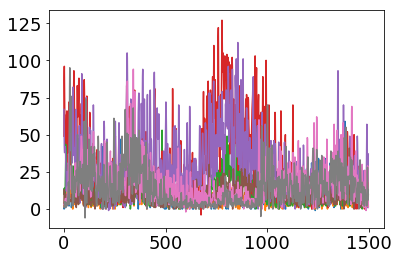

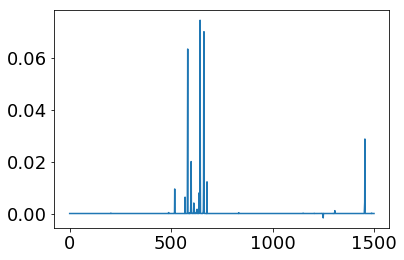

In [990]:
#Kernel ridge test
plt.plot(test)
plt.show()
plt.plot(clf.predict(test))
plt.show()

In [901]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
figs = [plt.figure(figsize=(25, 20)) for i in range(8)]
ax = [fig.add_subplot(111) for fig in figs]

for n, channel in enumerate(filtered_channels): 
    p = np.poly1d(np.polyfit(t, channel, order))
    for i, item in enumerate(channel):
        ax[n].scatter(i, item,color=colorst[n])
    ax[n].legend(["Channel " + str(n + 1)])
    ax[n].plot(p(t), linewidth=4.0)
plt.show()

TypeError: expected x and y to have same length

In [804]:
from matplotlib import pyplot as plt
from collections import deque
from threading import Lock, Thread
import myo
import numpy as np
import scipy.signal as sp
import csv
import time    

class EmgCollector(myo.DeviceListener):

    def __init__(self, n):
        self.n = n
        self.lock = Lock()
        self.emg_data_queue = deque(maxlen=n)
        self.data = []

    def get_emg_data(self):
        with self.lock:
            return list(self.emg_data_queue)

    # myo.DeviceListener

    def on_connected(self, event):
        event.device.stream_emg(True)

    def on_emg(self, event):
        with self.lock:
            self.emg_data_queue.append((event.timestamp, event.emg))
            self.data.append(event.emg)


class Plot(object):

    def __init__(self, listener):
        #self.arr = [[] * 8]
        
        self.n = listener.n
        self.listener = listener
        self.fig = plt.figure()
        self.axes = [self.fig.add_subplot('81' + str(i)) for i in range(1, 9)]
        [(ax.set_ylim([-100, 100])) for ax in self.axes]
        self.graphs = [ax.plot(np.arange(self.n), np.zeros(self.n))[0] for ax in self.axes]
        plt.ion()


    def update_plot(self):
        emg_data = self.listener.get_emg_data()
        
        emg_data = np.array([x[1] for x in emg_data]).T
        i = 0
        for g, data in zip(self.graphs, emg_data):
            if len(data) < self.n:
                # Fill the left side with zeroes.
                data = np.concatenate([np.zeros(self.n - len(data)), data])
               # self.arr[i].extend(data)
            data = self.process_data(data)
            g.set_ydata(data)
       # plt.draw()
        #print(emg_data.shape)
        return emg_data
    

    def process_data(self, data):
        # Rectify
        data = np.absolute(data)
       # print(data)
        # Remove mean
        data = data - np.mean(data)
        # Apply fitering
        b, a = sp.butter(4, 0.9, 'low')
        
        output_signal = sp.filtfilt(b, a, data)
        return output_signal

    def main(self, f):
        # root = tk.Tk()
        # t = TextWindow(root)

        while True:
            time.sleep(1/30)
        
            # Update text view
            # root.update()
            # root.update_idletasks()

        #print(myarr.shape)


def main():
    myo_file = open('TEST.csv', mode='w')
    myo.init(sdk_path='/Users/egor/Documents/University/myo_sdk')
    hub = myo.Hub()
    listener = EmgCollector(50)
    with hub.run_in_background(listener.on_event):
        while len(listener.data) < 1500:
            data = listener.get_emg_data()
    
    myoFile = csv.writer(myo_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    myoFile.writerows(np.abs(listener.data))
    myo_file.close()

if __name__ == '__main__':
    main()




In [760]:
loaded_model = model

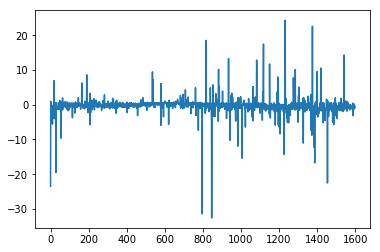

In [776]:
# Importing the dataset
dataset_test = pd.read_csv('TEST_RIGHT_LEFT.csv')
emg_test = dataset_test.values
pred = model.predict(emg_test)
plt.plot(pred)
plt.show()


In [26]:
from turtle import *
import math

apple = Turtle()

def polygon(t, n, length):
    for i in range(n):
        left(360/n)
        forward(length)

def draw_circle(t, r):
    circumference = 2 * math.pi * r
    n = 50
    length = circumference / n
    polygon(t, n, length)
    exitonclick()

draw_circle(apple, 30)

KeyboardInterrupt: 